In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import cv2 as cv
from draw import Canvas
from optimizers import SimulatedAnnealing, Parameter, mse
from ipywidgets import interact, IntSlider, Play, VBox, jslink

In [2]:
def discrete_normal(mu, sigma):
    while True:
        x = int(np.round(np.random.normal(mu, sigma)))
        if x != 0:
            return x

In [3]:
ref_image = cv.imread('../benchmark/img/flower.jpg')

In [4]:
ref_img_resize = cv.resize(
    ref_image, 
    dsize=(
        ref_image.shape[1]//6,
        ref_image.shape[0]//6))

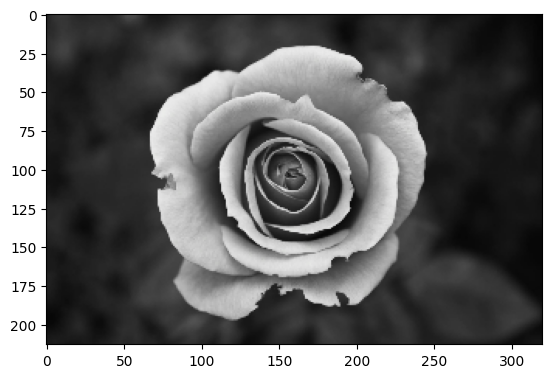

In [5]:
plt.imshow(ref_img_resize)

In [6]:
n_iterations = 10000

In [7]:
canvas = Canvas(resolution=ref_img_resize.shape[:2], cache_size=n_iterations)

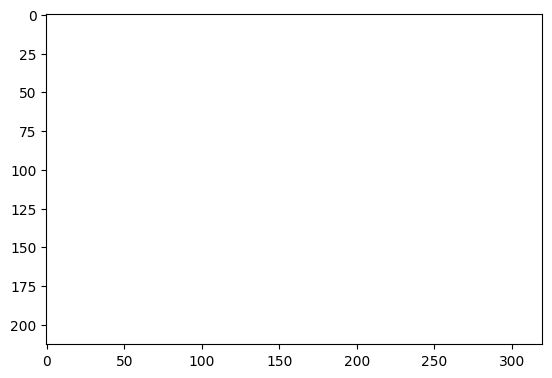

In [8]:
plt.imshow(canvas.canvas)

In [9]:
sa_optimizer = SimulatedAnnealing(
    max_iterations=n_iterations,
    loss=mse,
)

In [10]:
ref_img_resize.shape[:2]

(213, 320)

In [11]:
# coordinates of the center
center = Parameter(
    initial=(150, 100),
    step_size=30,
    min_value=(0, 0),
    max_value=ref_image.shape[:2]
)
# radius
radius = Parameter(
    initial=5,
    step_size=0,
    max_value=None,
    min_value=None
)
color = Parameter(
    initial=(0,0,0),
    step_size=30,
    min_value=(0,0,0),
    max_value=(255,255,255)
)

In [43]:
params = {
    'center': center,
    'radius': radius,
    'color': color
}

In [36]:
center.value

(150, 100)

In [41]:
center.update(np.random.randint)

In [42]:
center.value

(141, 91)

In [44]:
y_hat = sa_optimizer.optimize(
    canvas=canvas,
    parameters=params,
    reference=ref_img_resize,
    brush='circle')

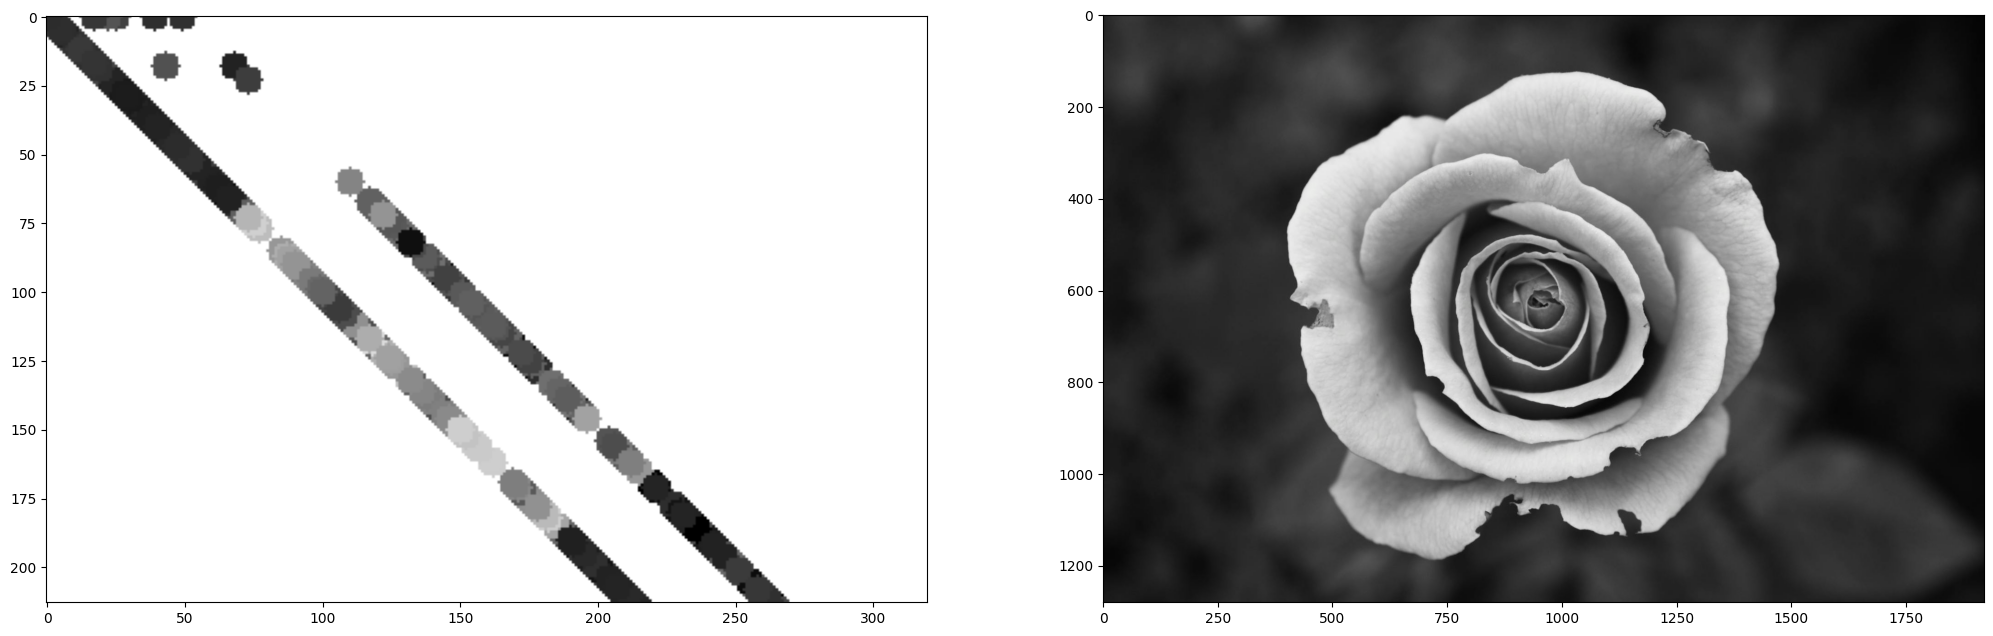

In [45]:
f, ax = plt.subplots(1,2, figsize=(25,25))
ax[0].imshow(canvas.canvas)
ax[1].imshow(ref_image)

In [47]:
err_img = (canvas.canvas-ref_img_resize)**2
err_img_rescale = err_img/np.nanmax(err_img)

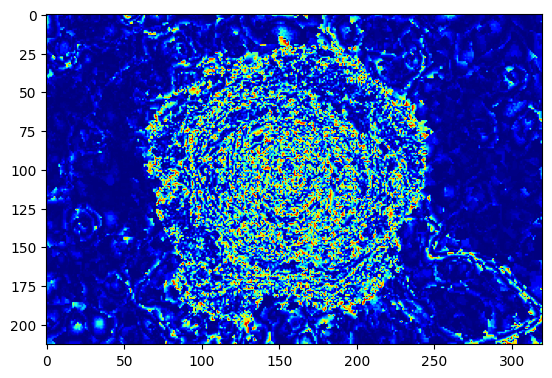

In [48]:
plt.imshow(err_img_rescale.mean(axis=2), cmap='jet')

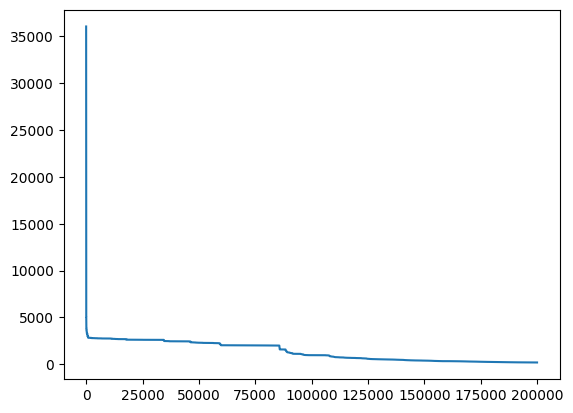

In [42]:
plt.plot(sa_optimizer._errors)

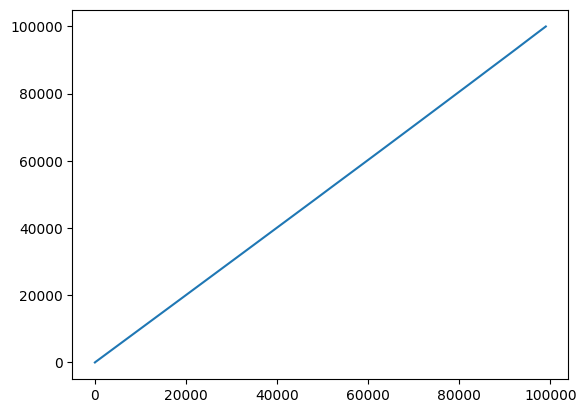

In [15]:
# simulate metropolis acceptance criteria, assuming averag delta E of -.00015
# initial temp of 1000
# and cooling rate of .99
sim_ac = [np.exp(-.00015/(1000*np.power(.99,x))) for x in range(4999)]
# plt.plot([np.exp(-.00015/(1000*np.power(.995,x))) for x in range(4999)])
plt.plot(np.array(sa_optimizer._entropy_norm))
# plt.ylim(0,1)
# plt.plot(sim_ac)
# plt.plot(sim_ac)
# plt.ylim(0,.0000001)

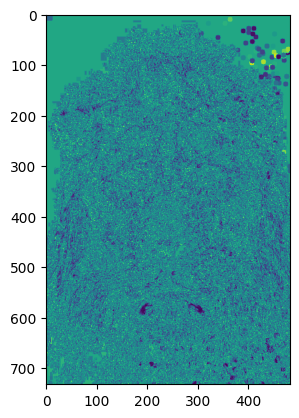

In [29]:
plt.imshow(((canvas._state_history[1000]-ref_img_resize)**2/255**2).mean(axis=2))

In [46]:
def show_state(canvas: Canvas, index: int) -> None:
    """Display a specific state of the canvas."""
    if index < 0 or index >= canvas._history_index:
        print("Invalid index.")
        return
    # err_img = (canvas._state_history[index]-ref_img_resize)**2
    # err_img_norm = (err_img/256**2).mean(axis=2)
    plt.imshow(canvas._state_history[index])
    plt.axis('off')
    plt.title(f"State {index}")
    # plt.show()


# Creating a function to setup interactive controls in Jupyter
def visualize_canvas_history(canvas: Canvas) -> None:
    """Visualize the canvas history with slider and play button."""
    slider = IntSlider(value=0, min=0, max=canvas._history_index - 1, step=1, description='State')
    play = Play(interval=1, value=0, min=0, max=canvas._history_index - 1, step=1, description="Play")

    # Link play and slider widgets
    jslink((play, 'value'), (slider, 'value'))

    interact(lambda index: show_state(canvas, index), index=slider)
    display(VBox([play, slider]))

In [47]:
visualize_canvas_history(canvas)

(array([288., 379., 338., 369., 355., 394., 391., 395., 383., 390., 395.,
        399., 400., 392., 392., 397., 392., 395., 396., 398., 393., 393.,
        395., 391., 395., 398., 389., 392., 395., 389., 396., 387., 389.,
        395., 393., 394., 391., 396., 391., 395., 389., 386., 392., 390.,
        387., 396., 393., 394., 309., 388., 388., 389., 392., 383., 394.,
        391., 382., 393., 374., 390., 386., 396., 392., 363., 390., 383.,
        390., 396., 392., 393., 391., 369., 311., 387., 367., 256., 327.,
        329., 372., 305., 372., 394., 395., 394., 288., 323., 274., 346.,
        378., 291., 368., 383., 386., 398., 396., 394., 393., 393., 368.,
        318.]),
 array([3.000000e+00, 4.029600e+02, 8.029200e+02, 1.202880e+03,
        1.602840e+03, 2.002800e+03, 2.402760e+03, 2.802720e+03,
        3.202680e+03, 3.602640e+03, 4.002600e+03, 4.402560e+03,
        4.802520e+03, 5.202480e+03, 5.602440e+03, 6.002400e+03,
        6.402360e+03, 6.802320e+03, 7.202280e+03, 7.602240e+03

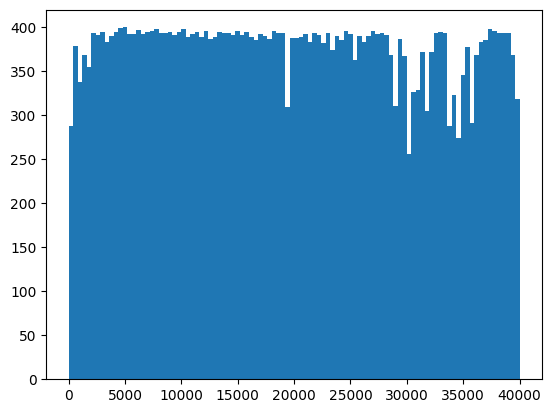

In [15]:
plt.hist(sa_optimizer._entropy_norm, bins=100)